# Experiments with different methods

- SVRG vs L-SVRG
- SARAH vs PAGE


In [11]:
import operator
import time
import warnings
from itertools import accumulate
from typing import Callable, Iterable, Literal, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cycler import cycler
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [12]:
MANUAL_SEED = 42
np.random.seed(MANUAL_SEED)

## Data loading


In [13]:
def load_MNIST_binary() -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    df = pd.read_csv("../data/interim/mnist_binary.csv", index_col=None)

    y, X = df.iloc[:, 0].to_numpy(), df.iloc[:, 1:].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42
    )

    return X_train, y_train, X_test, y_test


def load_mushrooms() -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    data = load_svmlight_file("../data/raw/mushrooms.txt")
    X, y = data[0].toarray(), data[1]
    y = 2 * y - 3

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    return X_train, y_train, X_test, y_test


def load_dataset(
    dataset: Literal["MNIST_binary"] | Literal["mushrooms"],
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    if dataset == "MNIST_binary":
        return load_MNIST_binary()
    return load_mushrooms()

In [14]:
X_train, Y_train, X_test, Y_test = load_dataset("MNIST_binary")

In [15]:
print(f"{X_train.shape=}, {Y_train.shape=}")
print(f"{X_test.shape=}, {Y_test.shape=}")

X_train.shape=(1800, 784), Y_train.shape=(1800,)
X_test.shape=(200, 784), Y_test.shape=(200,)


In [16]:
DATA_SIZE = Y_train.shape[0]

## Problems


In [17]:
class Problem:
    def get_value(self, w: np.ndarray, batch_idx: Optional[int] = None) -> float:
        raise NotImplementedError

    def get_gradient(self, w: np.ndarray, batch_idx: Optional[int] = None) -> np.ndarray:
        raise NotImplementedError

    def get_batch_size(self) -> int:
        raise NotImplementedError

    def get_batches_number(self) -> int:
        raise NotImplementedError

    def get_data_size(self) -> int:
        raise NotImplementedError

    def predict(self, x_values: np.ndarray, w: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def get_batch_indices(self, n: int) -> np.ndarray:
        raise NotImplementedError

In [18]:
def batch_data(data: list, batch_size: int) -> list:
    return [data[i : i + batch_size] for i in range(0, len(data), batch_size)]


def generate_batches(
    x_values: np.ndarray,
    y_values: np.ndarray,
    batch_size: int,
    seed: Optional[float] = 42,
) -> list[list[tuple[np.ndarray, float]]]:
    data = list(zip(x_values, y_values))
    if batch_size == 0:
        return [data]
    if seed is not None:
        np.random.seed(seed)
    np.random.shuffle(data)
    return batch_data(data, batch_size)


def divide_into_s_batches(
    x_values: np.ndarray,
    y_values: np.ndarray,
    s: int,
    seed: Optional[float] = 42,
) -> list[list[tuple[np.ndarray, float]]]:
    return generate_batches(x_values, y_values, DATA_SIZE // s, seed)[:s]

### Binary Logistic Regression


#### Definition


Binary Logistic Regression (BLR) problem can be defined as follows:

$$
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i) + \frac{\lambda}{2} \| w \|^2_2,
\end{equation}
$$

where $\ell(z,y) = \ln (1 + e^{-yz})$ is the loss function, $g(w, x) = w^T x$ is the model, $w$ is the model parameters, $\{x_i, y_i\}_{i=1}^n$ is the data sample from feature vectors $x_i$ and labels $y_i$, $\lambda > 0$ is the regularization parameter.

**Important Assumption**: $y$ must take values $-1$ or $+1$.


### Insights


**Lemma 1**
Let $x \in \mathbb{R}^d$. Then $X=xx^T \succeq 0$.

**Proof**
Let $y \in \mathbb{R}^d$ be column vector. Then

$$
y^TXy = y^Txx^Ty = (x^Ty)^T(x^Ty) = \|x^Ty\|_2^2 \geq 0
$$

Therefore, $X=xx^T$ is positive semi-definite by definition


**Lemma 2**
Let $x \in \mathbb{R}^d$. Then $(x^Tx)I_n \succeq xx^T$.

**Proof**
Let us denote $X =xx^T$, $r = x^Tx = \|x\|_2^2$ and $X' = X-rI_n$.  
Now let's look on calculation of eigenvalues for matrix $X'$.
We will have to calculate determinant of $X'-\lambda I_n = X-r I_n - \lambda I_n = X-(r + \lambda)I$.  
So we can claim that eigenvalues of $X'$ are just eigenvalues of $X$ minus $r$ (let us denote this fact as $eig(X')=eig(X)-r$).  
Then also recap property of definite matrix: matrix is positive definite if and only if all of its eigenvalues are positive.

Therefore, we need to prove that eigenvalues of $-X' = rI_n - X$ are nonnegative, what means that eigenvalues of $X' = X - rI_n $ are non-positive.

It is sufficient to show that the maximum eigenvalue $eig_{max}(X')$ is non-positive. We have shown that $eig(X')=eig(X)-r$.  
As $r \geq 0$, $eig_{max}(X') = eig_{max}(X') - r$.  
Note that $Sum(eig(X))=Tr(X)= r$, and, by _Lemma 1_, $X \succeq 0$, so all eigenvalue of $X$ are nonnegative.  
Therefore, the maximum possible $eig_{max}(X') \leq r$ and $eig_{max}(X') = eig_{max}(X') - r \leq 0$.

We has proven that $eig_{max}(X') \leq 0$, so $eig(X') \leq 0$ and $eig(-X') \geq 0$. Therefore, $-X' = (x^Tx)I_n - xx^T \succeq 0$


Let us define the function $f$ as
$$ f = \frac{1}{n} \sum\limits\_{i=1}^n \ell (g(w, x_i), y_i) + \frac{\lambda}{2} \| w \|^2_2$$

So the initial problem is minimizing $f$. Let us also use the following notations:

$$
e_i = e^{-y_iw^Tx_i} \\
h_i(w) = \ell (g(w, x_i), y_i) = ln(1+e^{-y_iw^Tx_i}) = ln(1+e_i) \\
r(w) = \frac{\lambda}{2} \| w \|^2_2 = \frac{\lambda}{2} w^Tw
$$

To compute $\nabla_w f$ and $\nabla_w^2 f$, we first need to find $\nabla h_i$, $\nabla^2 h_i$, $\nabla r$ and $\nabla^2 r$.
Note that $e_i' = -y_ie_ix_i$.

Let us start with $h(w)$:

$$
\nabla h_i = \frac{-y_ie_ix_i}{1+e_i} \\
\nabla^2 h_i = \frac{1}{(1+e_i)^2} (-y_i(-y_ie_ix_i)x_i(1+e_i)-(-y_ie_ix_i)(-y_ie_ix_i)) = \\
= \frac{y_i^2e_ix_ix_i^T}{(1+e_i)^2} (1+e_i-e_i) =  \{ y_i^2 = 1 \text{ as } y_i = \pm 1 \} = \frac{e_ix_ix_i^T}{(1+e_i)^2}
$$

For $r(w)$,

$$
\nabla r = \lambda w\\
\nabla^2 r = \lambda I_n
$$

Therefore,

$$
\nabla f = \frac{1}{n} \sum\limits_{i=1}^n \nabla h_i(w) +  \nabla r(w) = \frac{1}{n} \sum\limits_{i=1}^n \frac{-y_ie_ix_i}{1+e_i} +  \lambda w\\

\nabla^2 f = \frac{1}{n} \sum\limits_{i=1}^n \nabla^2 h_i(w) + \nabla^2 r(w) =\frac{1}{n} \sum\limits_{i=1}^n \frac{e_ix_ix_i^T}{(1+e_i)^2} + \lambda I_n
$$

From Theorem 2.1.6 and Theorem 2.1.11 from Nesterov's book (check references) we know that $f$ is $\mu$-strongly convex and has $L$-Lipschitz gradient iff

$$
L  I_n \succeq \nabla^2 f \succeq \mu I_n
$$

Note that $e_i > 0$, so $\frac{1}{n} \sum\limits_{i=1}^n \frac{e_ix_ix_i^T}{(1+e_i)^2} + \lambda I_n \succeq \lambda I_n$ (using _Lemma 1_).
Therefore $\nabla^2 f \succeq \lambda I_n$ and $f$ is $\mu$-strongly convex with $\mu = \lambda$.

Let us prove that $f$ has $L$-Lipschitz gradient with $L = \lambda + \frac{1}{4n} \sum_{i=1}^n x_i^T x_i$. To do this we need to show that

$$
(\lambda + \frac{1}{4n} \sum_{i=1}^n x_i^T x_i)I_n \succeq \frac{1}{n} \sum\limits_{i=1}^n \frac{e_ix_ix_i^T}{(1+e_i)^2} + \lambda I_n \\
\Longleftrightarrow \\
(\frac{1}{4n} \sum_{i=1}^n x_i^T x_i)I_n \succeq \frac{1}{n} \sum\limits_{i=1}^n \frac{e_ix_ix_i^T}{(1+e_i)^2}
$$

Let us focus on some fixed $x_i$ and prove
$$(\frac{1}{4n} x_i^T x_i)I_n \succeq \frac{1}{n} \frac{e_ix_ix_i^T}{(1+e_i)^2}$$

Using the fact that $x_i^T x_i I_n \succeq  x_ix_i^T$ from _Lemma 2_, we can compare only matrix scalars and proceed with following

$$
\frac{1}{4n} \geq \frac{1}{n} \frac{e_i}{(1+e_i)^2} \\
\frac{1}{4} \geq  \frac{e_i}{(1+e_i)^2} \\
(1+e_i)^2 \geq 4e_i \\
(1-e_i)^2 \geq 0 \\
$$

The last statement is true for all $x_i$, so $L I_n \succeq \nabla^2 f$ is also true and $f$ has $L$-Lipschitz gradient with $L = \lambda + \frac{1}{4n} \sum_{i=1}^n x_i^T x_i$.


**Results**

- $\nabla f = \frac{1}{n} \sum\limits_{i=1}^n \frac{-y_ie_ix_i}{1+e_i} +  \lambda w$
- The problem is $\mu$-strongly convex with $\mu = \lambda$
- The problem has $L$-Lipschitz gradient $L = \lambda + \frac{1}{4n} \sum_{i=1}^n \| x_i\|^2_2$


### Code


In [19]:
def calculate_blr_parameters(
    lambda_ratio: float, x_values: np.ndarray
) -> tuple[float, float, float]:
    """Calculate required parameters
    for the binary logistic regression problem

    Args:
        lambda_ratio (float): defined as `lambda_term = lambda_ratio * lipschitz`
        x_values (np.ndarray): training part

    Returns:
        tuple[float,float,float]: (lambda, mu, lipschitz)
    """

    products_sum = 0
    for x in x_values:
        products_sum += x @ x

    lipschitz = float(products_sum / (4 * x_values.shape[0] * (1 - lambda_ratio)))
    lambda_term = lambda_ratio * lipschitz
    mu = lambda_term

    return lambda_term, mu, lipschitz

In [20]:
LAMBDA_BLR, MU_BLR, LIPSCHITZ_BLR = calculate_blr_parameters(1e-3, X_train)

In [21]:
class BinaryLogisticRegression(Problem):
    def _expand_dim(self, x: np.ndarray) -> np.ndarray:
        """Convert (n,) vector to (n,1)"""
        return np.expand_dims(x, axis=1)

    def _custom_exponent(self, x: np.ndarray, y: float, w: np.ndarray) -> float:
        return np.exp(-y * w.dot(x))

    def _get_data(self, batch_idx: Optional[int]) -> list[tuple[np.ndarray, float]]:
        if batch_idx is None:
            # choose uniformly from batches
            idx = np.random.randint(0, self.num_batches)
            return self.batched_data[idx]

        if batch_idx < 0:
            # return full data
            return self.all_data

        return self.batched_data[batch_idx]

    def _predict(self, w: np.ndarray, x: np.ndarray) -> float:
        # As y can be 1 and -1 only, we are interested only in sign
        return np.sign(w.dot(x))

    def __init__(
        self,
        batched_data: list[list[tuple[np.ndarray, float]]],
        lambda_term: float = LAMBDA_BLR,
        seed: float = MANUAL_SEED,
    ) -> None:
        np.random.seed(seed)

        self.lambda_term = lambda_term

        self.all_data = []
        for d in batched_data:
            self.all_data.extend(d)

        self.batched_data = batched_data
        self.num_batches = len(self.batched_data)
        self.batch_size = len(self.batched_data[0])

        self.grad_shape = self.all_data[0][0].shape[0]

    def get_value(self, w: np.ndarray, batch_idx: Optional[int] = None) -> float:
        data = self._get_data(batch_idx)
        sum_result = 0
        for x, y in data:
            sum_result += np.log(1 + self._custom_exponent(x, y, w))

        squared_norm: float = w.dot(w)

        return sum_result / len(data) + squared_norm * self.lambda_term / 2

    def get_gradient(self, w: np.ndarray, batch_idx: Optional[int] = None) -> np.ndarray:
        data = self._get_data(batch_idx)
        sum_result = np.zeros(self.grad_shape)
        for x, y in data:
            custom_exp = self._custom_exponent(x, y, w)
            sum_result += (-y * custom_exp * x) / (1 + custom_exp)

        return sum_result / len(data) + self.lambda_term * w

    def get_batch_size(self):
        return self.batch_size

    def get_batches_number(self):
        return self.num_batches

    def get_data_size(self):
        return len(self.all_data)

    def predict(self, x_values: np.ndarray, w: np.ndarray) -> np.ndarray:
        return np.array([self._predict(w, x) for x in x_values])

    def get_batch_indices(self, n: int = 1) -> np.ndarray:
        return np.random.choice(range(self.num_batches), n, replace=False)

In [22]:
blr_ = BinaryLogisticRegression(generate_batches(X_train, Y_train, 10))

w_ = np.ones(X_train.shape[1])

print(f"{blr_.get_value(w_,-1)=}")
print(f"{blr_.get_gradient(w_).shape=}")

blr_.get_value(w_,-1)=76.21570340256963
blr_.get_gradient(w_).shape=(784,)


## Methods


Maximum iterations: 1000

Required precision $\varepsilon  =10^{-5}$

$\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$ is used as default convergence criterion.


In [23]:
NUM_ITERATIONS = 1000
NUM_ITERATIONS = 100
EPSILON = 1e-5

np.random.seed(420)
START_POINT = np.random.randn(X_train.shape[1])

In [24]:
IterationType = Literal["iterations"] | Literal["gradients"] | Literal["time"]


class Method:
    def _log_accuracy(self) -> float:
        accuracy = 0
        if not self.accuracy_logging:
            return accuracy

        predictions = self.f.predict(self.test_values, self.w_curr)

        if len(predictions) == 0:
            self.accuracy_logs.append(accuracy)
            return accuracy

        accuracy = (predictions == self.test_targets).sum() / self.test_targets.shape[0]
        self.accuracy_logs.append(accuracy)
        return accuracy

    def _log_data_points(self):
        accuracy = 0
        if not self.accuracy_logging:
            return accuracy

        predictions = self.f.predict(self.test_values, self.w_curr)

        if len(predictions) == 0:
            self.accuracy_logs.append(accuracy)
            return accuracy

        accuracy = (predictions == self.test_targets).sum() / self.test_targets.shape[0]
        self.accuracy_logs.append(accuracy)
        return accuracy

    def _accumulate(self, values: Iterable) -> list:
        return list(accumulate(values, operator.add))

    def __init__(
        self,
        name: str,
        f: Problem,
        w_0: np.ndarray,
        epsilon: float = EPSILON,
        verbose: bool = False,
    ) -> None:
        """Method base class

        Args:
            name (str): Method name
            f (Function)
            w_0 (np.ndarray): starting point
            epsilon (float):Required precision. Defaults to EPSILON
            verbose (bool): Defaults to False
        """

        self.name = name
        self.f = f
        self.w_0 = w_0.copy()
        self.epsilon = epsilon
        self.verbose = verbose

        self.accuracy_logging = False

        self.func_batch_size = f.get_batch_size()

        self.get_iterations_check: dict[IterationType, Callable[[], float]] = {
            "iterations": lambda: self.total_pass_iterations,
            "gradients": lambda: self.total_used_gradients,
            "time": lambda: self.total_passed_time,
        }

        self.get_iterations_update: dict[IterationType, Callable[[], float]] = {
            "iterations": lambda: 1,
            "gradients": lambda: self.used_gradients,
            "time": lambda: self.passed_time,
        }

        self.reset()

    def enable_accuracy_logging(self, test_values: np.ndarray, test_targets: np.ndarray):
        self.accuracy_logging = True
        self.test_values = test_values
        self.test_targets = test_targets

    def disable_accuracy_logging(self):
        self.accuracy_logging = False

    def predict(self, x_values: np.ndarray) -> np.ndarray:
        return self.f.predict(x_values, self.w_sol)

    def get_name(self) -> str:
        return self.name

    def get_solution(self) -> np.ndarray:
        return self.w_sol

    def get_pass_iterations_logs(self) -> list[int]:
        return list(range(self.total_pass_iterations + 1))

    def get_used_gradients_logs(self) -> list[int]:
        return self.used_gradients_logs

    def get_time_logs(self) -> list[float]:
        return self.time_logs

    def get_accumulated_time_logs(self) -> list[float]:
        return self.time_logs

    def get_accuracy_logs(self) -> list[float]:
        return self.accuracy_logs

    def get_criterion_logs(self) -> list[float]:
        return self.criterion_logs

    def update(self, iteration: int) -> bool:
        raise NotImplementedError

    def calculate_criterion(self, k: int) -> float:
        full_grad_current = self.f.get_gradient(self.w_curr, -1)  # on full_data
        return float(
            np.linalg.norm(full_grad_current) / np.linalg.norm(self.full_grad_0)  # type: ignore
        )

    def reset(self):
        self.criterion_logs = []
        self.time_logs = []
        self.accuracy_logs = []
        self.used_gradients_logs = []

        self.used_gradients = 0
        self.transmitted_info = 0
        self.communications_number = 0
        self.passed_time = 0

        self.total_used_gradients = 0
        self.total_pass_iterations = 0
        self.total_passed_time = 0

        self.w_prev = self.w_0.copy()
        self.w_curr = self.w_0.copy()
        self.w_sol = self.w_0.copy()

        self.full_grad_0 = self.f.get_gradient(self.w_0, -1)

    def start(
        self,
        max_iterations: float = NUM_ITERATIONS,
        iteration_type: IterationType = "iterations",
    ) -> np.ndarray:
        """Start iterating

        Returns:
            np.ndarray: solution
        """
        self.reset()

        if not self.verbose:
            progress_bar = tqdm(
                total=max_iterations, desc=self.name, leave=True, position=0
            )

        iterations_check = self.get_iterations_check[iteration_type]
        iterations_update = self.get_iterations_update[iteration_type]

        # logging
        self.time_logs.append(0)
        self.criterion_logs.append(self.calculate_criterion(0))
        self.used_gradients_logs.append(0)
        accuracy = self._log_accuracy()

        while iterations_check() < max_iterations:
            k = self.total_pass_iterations

            self.used_gradients = 0
            self.transmitted_info = 0
            self.communications_number = 0

            start_time = time.time()
            succeeded = self.update(k)
            finish_time = time.time()
            self.passed_time = finish_time - start_time

            if not succeeded:  # diverges
                break

            self.total_pass_iterations += 1
            self.total_used_gradients += self.used_gradients
            self.total_passed_time += self.passed_time

            # logging
            self.time_logs.append(self.total_passed_time)
            criterion_value = self.calculate_criterion(k)
            self.criterion_logs.append(criterion_value)
            self.used_gradients_logs.append(self.total_used_gradients)
            accuracy = self._log_accuracy()

            if not self.verbose:
                info_dict = {"time": self.passed_time, "criterion": criterion_value}
                if self.accuracy_logging:
                    info_dict.update({"accuracy": accuracy})

                progress_bar.set_postfix(info_dict)  # type: ignore
                progress_bar.update(iterations_update())  # type: ignore

            if np.isnan(criterion_value):  # diverges
                break
            if criterion_value < self.epsilon:
                break

        self.w_sol = self.w_curr.copy()

        if not self.verbose:
            progress_bar.close()  # type: ignore

        return self.w_sol

### SVRG


In [25]:
class SVRG(Method):
    def __init__(
        self,
        f: Problem,
        w_0: np.ndarray,
        step_size: Callable[[int], float],
        epoch_length: int,
        epsilon: float = EPSILON,
        verbose: bool = False,
        label: Optional[str] = None,
    ) -> None:
        name = "SVRG"
        if label is not None:
            name = f"{name} | {label}"
        super().__init__(name, f, w_0, epsilon, verbose)
        self.step_size = step_size
        self.epoch_length = epoch_length

        self.batch_size = self.f.get_batch_size()
        self.batches_number = f.get_batches_number()
        self.data_size = f.get_data_size()

    def update(self, iteration: int) -> bool:
        learning_rate = self.step_size(iteration)

        w_tilde = self.w_curr.copy()
        full_grad = self.f.get_gradient(w_tilde, -1)

        inside_w = w_tilde.copy()
        aggregated_w = inside_w.copy()

        for _ in range(self.epoch_length):
            i = np.random.randint(self.batches_number)

            g_k = (
                self.f.get_gradient(inside_w, i)
                - self.f.get_gradient(w_tilde, i)
                + full_grad
            )
            inside_w = inside_w - learning_rate * g_k
            aggregated_w += inside_w

        next_w = aggregated_w / self.epoch_length

        self.w_prev = self.w_curr.copy()
        self.w_curr = next_w.copy()

        self.used_gradients = self.data_size + 2 * self.epoch_length * self.batch_size

        return True

### L-SVRG


In [26]:
class LSVRG(Method):
    def __init__(
        self,
        f: Problem,
        w_0: np.ndarray,
        step_size: Callable[[int], float],
        probability: float,
        epsilon: float = EPSILON,
        verbose: bool = False,
        label: Optional[str] = None,
    ) -> None:
        name = "L-SVRG"
        if label is not None:
            name = f"{name} | {label}"
        super().__init__(name, f, w_0, epsilon, verbose)
        self.step_size = step_size
        self.probability = probability

        self.batch_size = self.f.get_batch_size()
        self.batches_number = f.get_batches_number()
        self.data_size = f.get_data_size()

    def reset(self):
        super().reset()
        self.w_tilde = self.w_0.copy()
        self.grad_w_tilde = self.f.get_gradient(self.w_tilde, -1)

    def update(self, iteration: int) -> bool:
        i = np.random.randint(self.batches_number)
        grad = (
            self.f.get_gradient(self.w_curr, i)
            - self.f.get_gradient(self.w_tilde, i)
            + self.grad_w_tilde
        )

        next_w = self.w_curr - self.step_size(iteration) * grad

        if np.random.random() < self.probability:
            self.w_tilde = self.w_curr.copy()
            self.grad_w_tilde = self.f.get_gradient(self.w_tilde, -1)

            self.used_gradients += self.data_size

        self.w_prev = self.w_curr.copy()
        self.w_curr = next_w.copy()

        self.used_gradients += 2 * self.batch_size

        return True

#### SARAH


In [27]:
class SARAH(Method):
    def __init__(
        self,
        f: Problem,
        w_0: np.ndarray,
        step_size: Callable[[int], float],
        epoch_length: int,
        epsilon: float = EPSILON,
        verbose: bool = False,
        label: Optional[str] = None,
    ) -> None:
        name = "SARAH"
        if label is not None:
            name = f"{name} | {label}"
        super().__init__(name, f, w_0, epsilon, verbose)
        self.step_size = step_size
        self.epoch_length = epoch_length

        self.batch_size = self.f.get_batch_size()
        self.batches_number = f.get_batches_number()
        self.data_size = f.get_data_size()

    def update(self, iteration: int) -> bool:
        learning_rate = self.step_size(iteration)

        ws = [self.w_curr.copy()]
        v = self.f.get_gradient(self.w_curr, -1)
        ws.append(self.w_curr - learning_rate * v)

        stop_idx = np.random.randint(self.epoch_length)

        for _ in range(stop_idx - 1):
            i = np.random.randint(self.batches_number)

            v = self.f.get_gradient(ws[-1], i) - self.f.get_gradient(ws[-2], i) + v
            ws.append(ws[-1] - learning_rate * v)

        next_w = ws[stop_idx]

        self.w_prev = self.w_curr.copy()
        self.w_curr = next_w.copy()

        self.used_gradients = self.data_size + 2 * (stop_idx + 1) * self.batch_size

        return True

### PAGE


In [28]:
class PAGE(Method):
    def _gradient_on_primary_batch(self, w: np.ndarray) -> np.ndarray:
        return (
            np.sum(
                [
                    self.f.get_gradient(w, batch_idx=i)
                    for i in self.f.get_batch_indices(self.secondary_batch_size)
                ],
                axis=0,
            )
            / self.secondary_batch_size
        )

    def __init__(
        self,
        f: Problem,
        w_0: np.ndarray,
        step_size: Callable[[int], float],
        probability: float,
        epsilon: float = EPSILON,
        verbose: bool = False,
        label: Optional[str] = None,
    ) -> None:
        name = "PAGE"
        if label is not None:
            name = f"{name} | {label}"

        self.batch_size = f.get_batch_size()
        self.secondary_batch_size = self.batch_size
        self.primary_batch_size = self.secondary_batch_size**2
        super().__init__(name, f, w_0, epsilon, verbose)
        self.step_size = step_size
        self.probability = probability

        self.batches_number = f.get_batches_number()
        self.data_size = f.get_data_size()

    def reset(self):
        super().reset()
        self.g = self._gradient_on_primary_batch(self.w_0)
        self.ws = []

    def get_solution(self) -> np.ndarray:
        return np.random.choice(self.ws)

    def update(self, iteration: int) -> bool:
        next_w = self.w_curr - self.step_size(iteration) * self.g

        self.w_prev = self.w_curr.copy()
        self.w_curr = next_w.copy()

        if np.random.random() < self.probability:
            self.g = self._gradient_on_primary_batch(self.w_curr)

            self.used_gradients = self.primary_batch_size

            return True

        i = np.random.randint(self.batches_number)
        self.g = (
            self.g
            + self.f.get_gradient(self.w_curr, batch_idx=i)
            - self.f.get_gradient(self.w_prev, batch_idx=i)
        )

        self.used_gradients = 2 * self.secondary_batch_size

        return True

## Utilities


In [29]:
PREDEFINED_COLORS = [
    "#ffa500",
    "#c83cbc",
    "#1c1c84",
    "#ff0000",
    "#08a4a7",
    "#008000",
]


AxesValues = (
    Literal["criterion"]
    | Literal["accuracy"]
    | Literal["iterations"]
    | Literal["time"]
    | Literal["used_gradients"]
    | Literal["log_used_gradients"]
)
PREDEFINED_AXES_VALUES: dict[AxesValues, dict] = {
    "criterion": {
        "name": "Criterion",
        "label": "Criterion, log scale",
        "get_data": lambda m: m.get_criterion_logs(),
        "log": True,
    },
    "accuracy": {
        "name": "Accuracy",
        "label": "Accuracy",
        "get_data": lambda m: m.get_accuracy_logs(),
        "log": False,
    },
    "iterations": {
        "name": "Iterations",
        "label": "Iterations",
        "get_data": lambda m: m.get_pass_iterations_logs(),
        "log": False,
    },
    "time": {
        "name": "Time",
        "label": "Running time, seconds",
        "get_data": lambda m: m.get_accumulated_time_logs(),
        "log": False,
    },
    "used_gradients": {
        "name": "Used gradients",
        "label": "Used gradients",
        "get_data": lambda m: m.get_used_gradients_logs(),
        "log": False,
    },
    "log_used_gradients": {
        "name": "Used gradients",
        "label": "Used gradients, log scale",
        "get_data": lambda m: m.get_used_gradients_logs(),
        "log": True,
    },
}


PlotDescription = tuple[AxesValues, AxesValues]


def draw_method_plots(
    methods: list[Method],
    title: str,
    plots: list[PlotDescription],
    ylim=None,
    plot_width: float = 16,
    plot_height: float = 7,
    use_rainbow: bool = False,
    use_common_legend: bool = True,
):
    num_plots = len(plots)
    if use_rainbow:
        num_colors = len(methods)
        cm = plt.get_cmap("gist_rainbow")
        colors = [cm(1.0 * i / num_colors) for i in range(num_colors)]
    else:
        colors = PREDEFINED_COLORS

    style_cycler = cycler(linestyle=["-", "--", ":", "-."]) * cycler(color=colors)

    fig, axs = plt.subplots(num_plots, 1, figsize=(plot_width, plot_height * num_plots))
    fig.suptitle(title, fontsize=14)
    axs_list = [axs] if num_plots == 1 else list(axs.flat)

    for ax in axs_list:
        ax.grid()
        ax.set_prop_cycle(style_cycler)
        if ylim is not None:
            ax.set_ylim(top=ylim)

    for ax, (p1, p2) in zip(axs_list, plots):
        p1_data = PREDEFINED_AXES_VALUES[p1]
        p2_data = PREDEFINED_AXES_VALUES[p2]

        ax.set_title(f"{p2_data['name']} over {p1_data['name']}")
        ax.set(xlabel=p1_data["label"], ylabel=p2_data["label"])

        if p1_data["log"]:
            ax.set_xscale("log")
        if p2_data["log"]:
            ax.set_yscale("log")

        for method in methods:
            label = method.name

            x_values = p1_data["get_data"](method)
            y_values = p2_data["get_data"](method)

            ax.plot(x_values, y_values, label=label)
            ax.scatter(x_values[-1], y_values[-1], s=15)

    if use_common_legend:
        lines_labels = [axs_list[0].get_legend_handles_labels()]
        lines, labels = [sum(x, []) for x in zip(*lines_labels)]
        fig.legend(
            lines,
            labels,
            scatterpoints=1,
            markerscale=3,
            loc="outside lower center",
            ncol=min(5, len(methods)),
            bbox_to_anchor=(0.5, -0.05),
        )
    else:
        if len(methods) > 1:
            for ax in axs_list:
                ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))

    plt.tight_layout()
    plt.subplots_adjust(
        top=1 - 0.1 / (num_plots**0.5), bottom=0.12 / (num_plots**2), hspace=0.15
    )

## BLR Experiments


### Ex1. SVRG vs L-SVRG


In [30]:
SVRG_LR_DICT: dict[str, Callable[[int], float]] = {
    "SVRG": lambda _: 1 / LIPSCHITZ_BLR,
    "LSVRG": lambda _: 1 / LIPSCHITZ_BLR,
}
SVRG_S = 100
SVRG_P = 1 / SVRG_S


svrgs: list[Method] = [
    SVRG(
        BinaryLogisticRegression(divide_into_s_batches(X_train, Y_train, s=SVRG_S)),
        START_POINT,
        SVRG_LR_DICT["SVRG"],
        epoch_length=int(1 / SVRG_P),
    ),
    LSVRG(
        BinaryLogisticRegression(divide_into_s_batches(X_train, Y_train, s=SVRG_S)),
        START_POINT,
        SVRG_LR_DICT["LSVRG"],
        probability=SVRG_P,
    ),
]

for svrg in svrgs:
    svrg.enable_accuracy_logging(X_test, Y_test)
    _ = svrg.start(max_iterations=1e5, iteration_type="gradients")

SVRG:  59%|█████▉    | 59400/100000.0 [00:01<00:00, 46412.71it/s, time=0.093, criterion=0.105, accuracy=0.995]

SVRG: 102600it [00:01, 55279.23it/s, time=0.038, criterion=0.0764, accuracy=0.995]                             
L-SVRG: 100008it [00:36, 2734.59it/s, time=0.000977, criterion=0.0172, accuracy=1]                                 


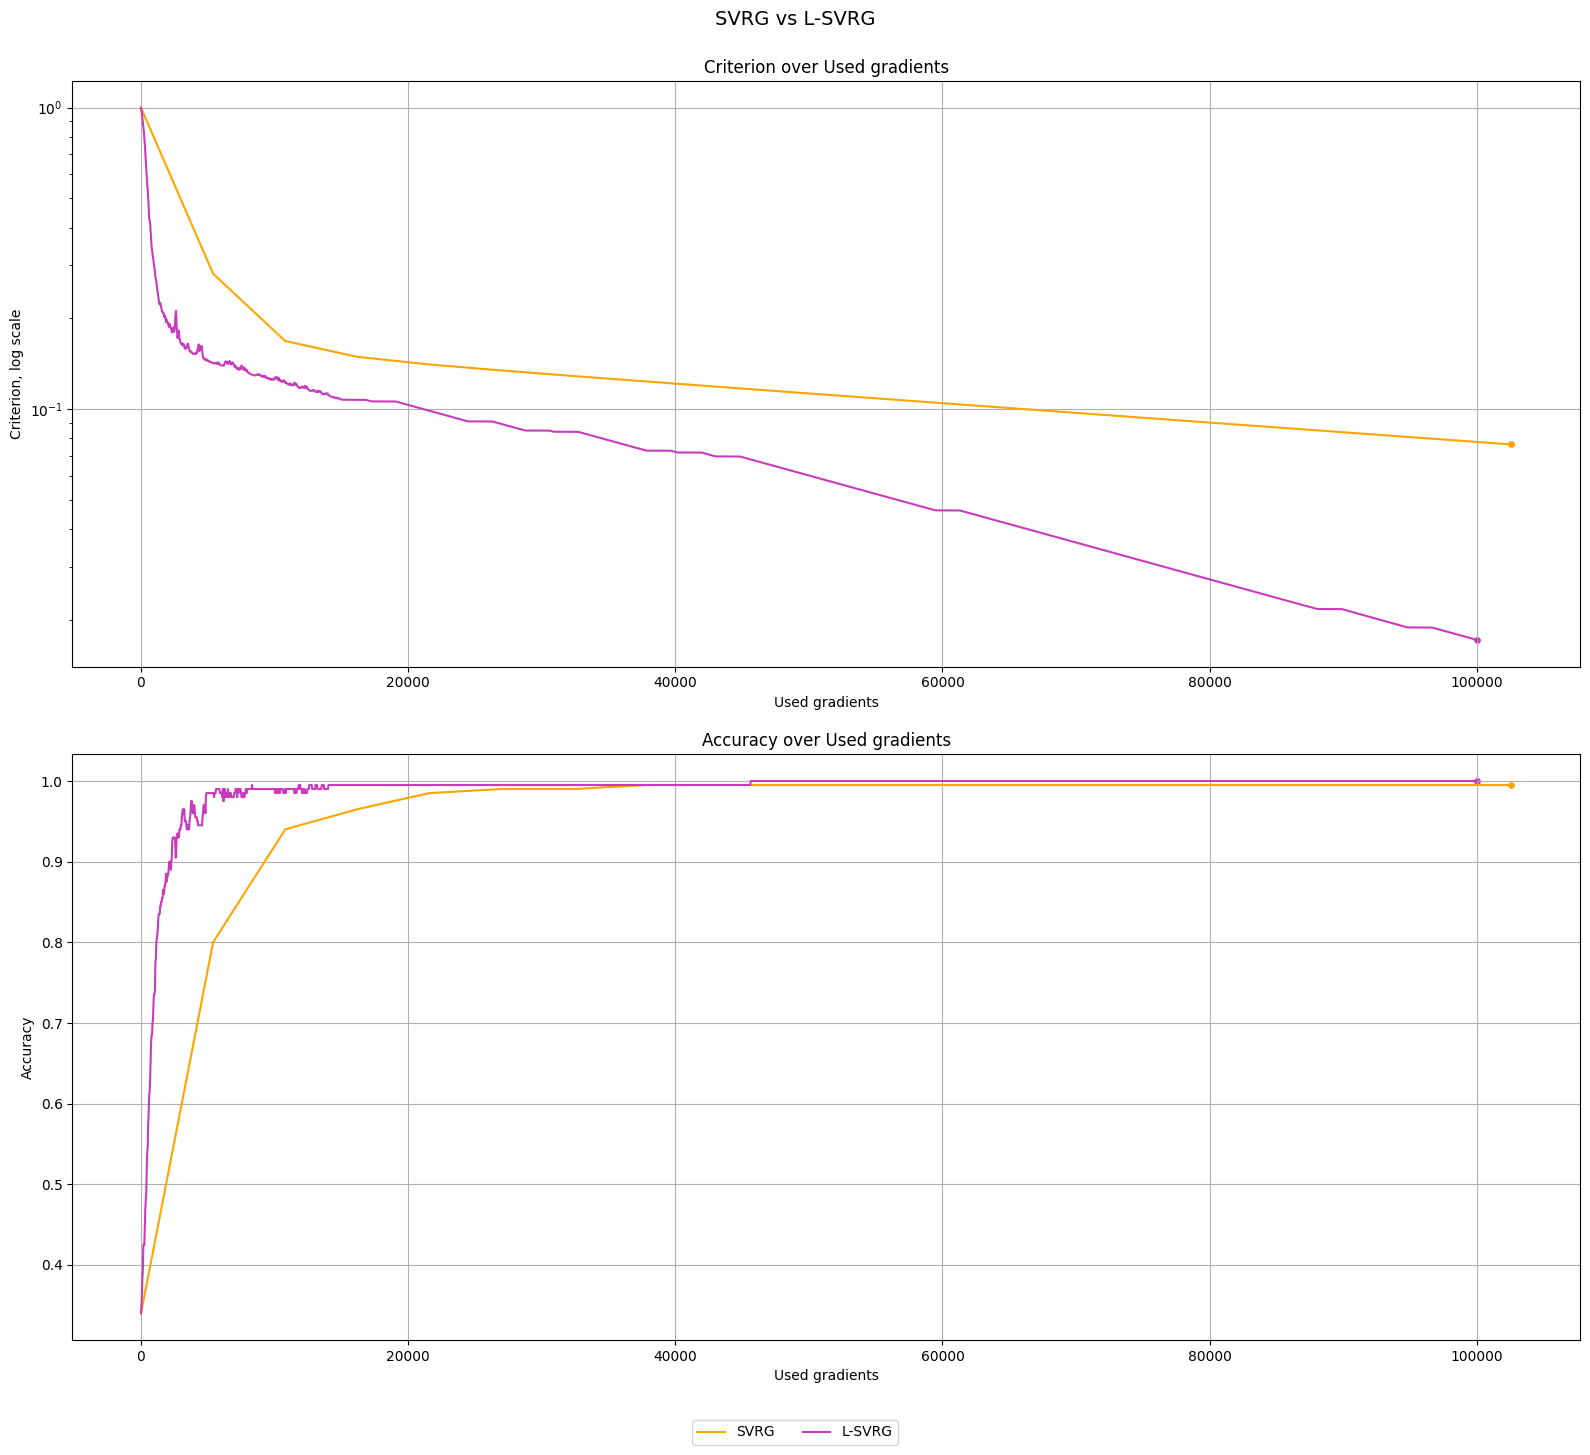

In [31]:
draw_method_plots(
    svrgs,
    plots=[("used_gradients", "criterion"), ("used_gradients", "accuracy")],
    title="SVRG vs L-SVRG",
)

### Ex2. SARAH vs PAGE


In [32]:
SARAH_LR_DICT: dict[str, Callable[[int], float]] = {
    "SARAH": lambda _: 1 / (2 * LIPSCHITZ_BLR),
    "PAGE": lambda _: 1 / (2 * LIPSCHITZ_BLR),
}

SARAH_B_SECONDARY = 10
SARAH_B_PRIMARY = SARAH_B_SECONDARY**2

SARAH_P = SARAH_B_SECONDARY / (SARAH_B_PRIMARY + SARAH_B_SECONDARY)


sarahs: list[Method] = [
    SARAH(
        BinaryLogisticRegression(generate_batches(X_train, Y_train, SARAH_B_PRIMARY)),
        START_POINT,
        SARAH_LR_DICT["SARAH"],
        epoch_length=DATA_SIZE // SARAH_B_PRIMARY,
    ),
    PAGE(
        BinaryLogisticRegression(generate_batches(X_train, Y_train, SARAH_B_SECONDARY)),
        START_POINT,
        SARAH_LR_DICT["PAGE"],
        probability=SARAH_P,
    ),
]

for sarah in sarahs:
    sarah.enable_accuracy_logging(X_test, Y_test)
    _ = sarah.start(max_iterations=1e5, iteration_type="gradients")

SARAH: 101000it [00:01, 83061.34it/s, time=0.035, criterion=0.152, accuracy=0.96]                               
PAGE: 100%|██████████| 100000/100000.0 [00:58<00:00, 1699.41it/s, time=0.000961, criterion=0.0266, accuracy=1]   


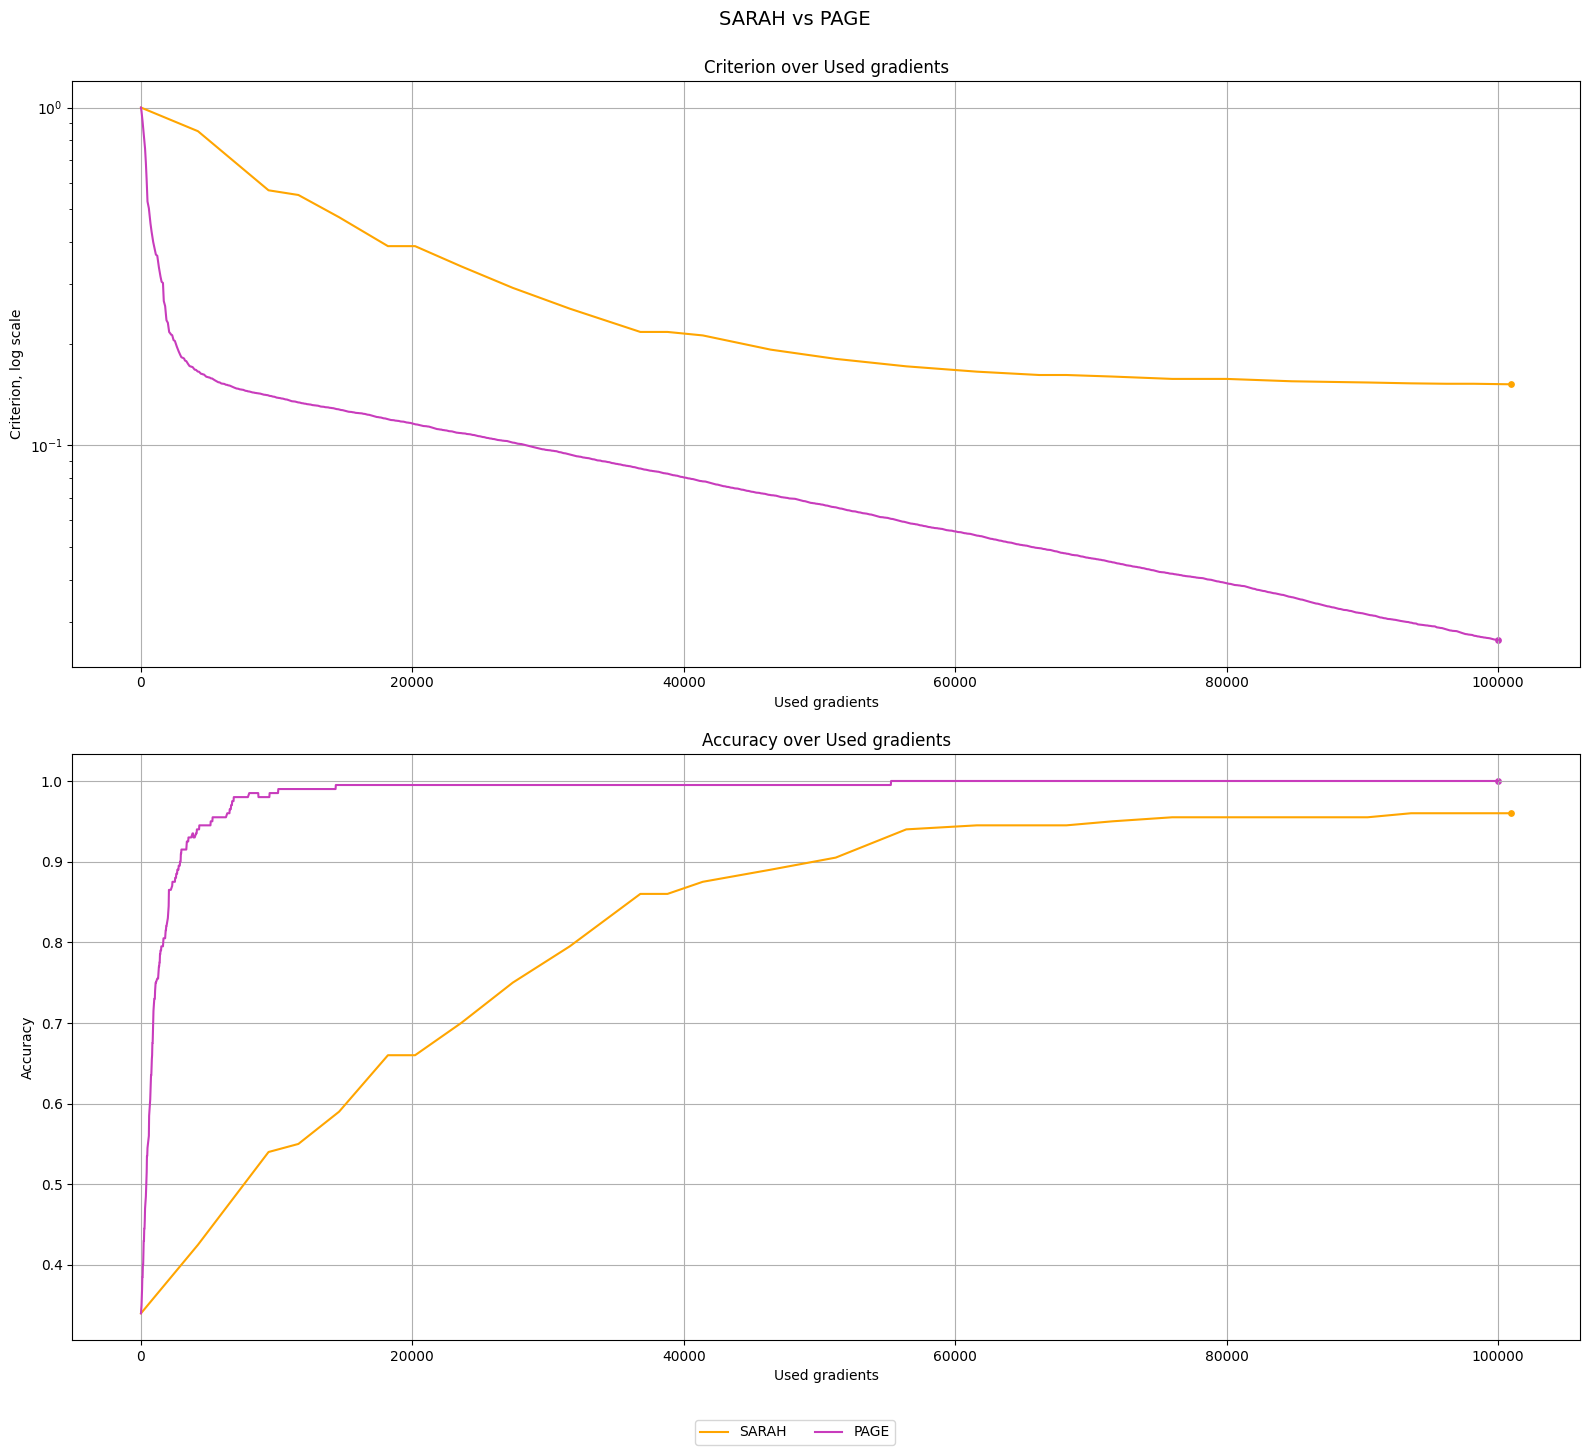

In [33]:
draw_method_plots(
    sarahs,
    plots=[("used_gradients", "criterion"), ("used_gradients", "accuracy")],
    title="SARAH vs PAGE",
)